In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [6]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 13))

In [7]:
rand_sub_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 24

In [8]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [9]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [10]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [11]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [12]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

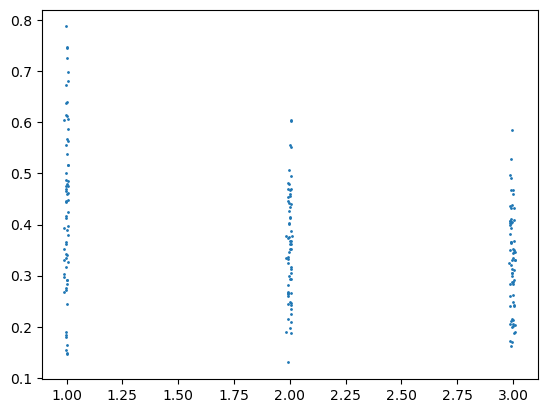

In [13]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [14]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [14]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [15]:
n_100206_all[:,37]

array([ 0.235762, -0.520906,  0.820409])

In [19]:
1/166 * (np.dot(n_100206_sub_no_b5.T, n_100206_sub_no_b5))

array([[ 0.3785666 ,  0.00319822, -0.00429285],
       [ 0.00319822,  0.39018517, -0.00542128],
       [-0.00429285, -0.00542128,  0.39992234]])

In [18]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(194, 3)


In [20]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [21]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [22]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.39it/s]


Loss: 567.129396234639
Average Loss: 0.07760391300419253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.37it/s]


Loss: 429.5671938844025
Average Loss: 0.05878040419874145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [02:22<00:00, 51.22it/s]


Loss: 427.6457526651211
Average Loss: 0.058517481207597304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:22<00:00, 88.72it/s]


Loss: 427.08090313896537
Average Loss: 0.058440189263678895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:31<00:00, 79.70it/s]


Loss: 425.6629735538736
Average Loss: 0.058246164963584236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.80it/s]


Loss: 425.31052877008915
Average Loss: 0.05819793770800344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.86it/s]


Loss: 425.0134708129335
Average Loss: 0.0581572893832695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.13it/s]


Loss: 424.6550461673178
Average Loss: 0.05810824386525969
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.38it/s]


Loss: 423.84266076935455
Average Loss: 0.0579970800177004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.93it/s]


Loss: 423.5701700691134
Average Loss: 0.05795979338657818
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▋                                                                                                                                                           | 124/7308 [00:03<01:01, 116.20it/s]

X_batch: 
torch.Size([128, 194])
tensor([[0.5160, 0.2355, 0.1331,  ..., 0.4651, 0.1344, 0.2512],
        [0.5077, 0.2685, 0.1491,  ..., 0.3656, 0.2994, 0.2440],
        [0.4286, 0.2589, 0.1604,  ..., 0.4829, 0.1484, 0.2536],
        ...,
        [0.3622, 0.4146, 0.2235,  ..., 0.2992, 0.5803, 0.5532],
        [0.3196, 0.1596, 0.0871,  ..., 0.2693, 0.1016, 0.1035],
        [0.2618, 0.4961, 0.4179,  ..., 0.4788, 0.3808, 0.4015]])
X_pred: 
torch.Size([128, 194])
tensor([[0.4512, 0.2380, 0.1375,  ..., 0.4432, 0.1466, 0.2338],
        [0.4544, 0.3051, 0.2305,  ..., 0.4411, 0.2436, 0.3076],
        [0.4715, 0.2515, 0.1472,  ..., 0.4652, 0.1523, 0.2516],
        ...,
        [0.4519, 0.3799, 0.3421,  ..., 0.4479, 0.3405, 0.4011],
        [0.3204, 0.1496, 0.0913,  ..., 0.3135, 0.0982, 0.1475],
        [0.4952, 0.4338, 0.3933,  ..., 0.4905, 0.3918, 0.4583]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.98it/s]


Loss: 423.4612627848983
Average Loss: 0.057944890912000314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.20it/s]


Loss: 423.11749917594716
Average Loss: 0.05789785155664302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.94it/s]


Loss: 422.35957931983285
Average Loss: 0.05779414057468977
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.25it/s]


Loss: 422.4563896881882
Average Loss: 0.05780738775153095
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.63it/s]


Loss: 422.991440620739
Average Loss: 0.05788060216485208
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.33it/s]


Loss: 422.1831026771106
Average Loss: 0.0577699921561454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.99it/s]


Loss: 422.7529323978815
Average Loss: 0.05784796557168603
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.08it/s]


Loss: 422.05394354392774
Average Loss: 0.05775231849260095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.80it/s]


Loss: 422.09275881922804
Average Loss: 0.05775762983295403
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.77it/s]


Loss: 421.68613585131243
Average Loss: 0.05770198903274664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.30it/s]


Loss: 421.6356292180717
Average Loss: 0.05769507788971972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.76it/s]


Loss: 421.6150824204087
Average Loss: 0.057692266341052095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.07it/s]


Loss: 420.8914064115379
Average Loss: 0.057593241161951
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.96it/s]


Loss: 421.41968195606023
Average Loss: 0.05766552845594694
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.84it/s]


Loss: 420.580183991231
Average Loss: 0.057550654623868505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.84it/s]


Loss: 420.7651523866225
Average Loss: 0.05757596502280001
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.33it/s]


Loss: 420.2721653061453
Average Loss: 0.05750850647319996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.82it/s]


Loss: 419.96829756954685
Average Loss: 0.057466926323145436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.19it/s]


Loss: 420.1289794626646
Average Loss: 0.05748891344590375
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.17it/s]


Loss: 419.7323959446512
Average Loss: 0.05743464640731407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.25it/s]


Loss: 419.73788665561005
Average Loss: 0.05743539773612617
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.40it/s]


Loss: 419.9266530426685
Average Loss: 0.05746122783835091
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.26it/s]


Loss: 419.3700584957842
Average Loss: 0.057385065475613596
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.56it/s]


Loss: 419.4174409210682
Average Loss: 0.05739154911344666
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.35it/s]


Loss: 418.9702028436586
Average Loss: 0.0573303506901558
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.89it/s]


Loss: 418.99744619382545
Average Loss: 0.05733407857058367
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.36it/s]


Loss: 418.9093853533268
Average Loss: 0.05732202864714379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.83it/s]


Loss: 419.14852577704005
Average Loss: 0.05735475174836344
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.30it/s]


Loss: 418.75236761709675
Average Loss: 0.05730054291421685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.47it/s]


Loss: 418.83224463718943
Average Loss: 0.05731147299359461
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.72it/s]


Loss: 418.62132533849217
Average Loss: 0.05728261156793817
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.02it/s]


Loss: 418.68053286056966
Average Loss: 0.057290713308780744
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.86it/s]


Loss: 418.61411783937365
Average Loss: 0.057281625320111336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.56it/s]


Loss: 418.48555009556003
Average Loss: 0.05726403258012589
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.78it/s]


Loss: 418.3255680666771
Average Loss: 0.05724214122423058
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.71it/s]


Loss: 418.5811394099146
Average Loss: 0.05727711267240211
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.47it/s]


Loss: 418.3643809342757
Average Loss: 0.057247452235122565
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.82it/s]


Loss: 418.2024832018651
Average Loss: 0.057225298741360855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.95it/s]


Loss: 416.0363281960599
Average Loss: 0.05692889001040776
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.94it/s]


Loss: 414.77432074351236
Average Loss: 0.056756201524837485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.21it/s]


Loss: 414.1984113594517
Average Loss: 0.056677396190401165
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.70it/s]


Loss: 413.169459650293
Average Loss: 0.05653659820064217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.00it/s]


Loss: 412.81372035690583
Average Loss: 0.05648792013641295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.16it/s]


Loss: 412.23611956392415
Average Loss: 0.05640888335576411
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.33it/s]


Loss: 411.81313423695974
Average Loss: 0.05635100359016964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.33it/s]


Loss: 411.9163102598395
Average Loss: 0.056365121819901415
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.88it/s]


Loss: 411.29993732087314
Average Loss: 0.05628077960055736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.61it/s]


Loss: 411.1026626175735
Average Loss: 0.05625378525144684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 166.07it/s]


Loss: 410.9108196629677
Average Loss: 0.05622753416296766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.46it/s]


Loss: 410.79003041633405
Average Loss: 0.05621100580409607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.18it/s]


Loss: 410.59019131818786
Average Loss: 0.05618366055257086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.12it/s]


Loss: 410.3080917026382
Average Loss: 0.05614505907261059
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.57it/s]


Loss: 410.1405073062051
Average Loss: 0.056122127436536
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.05it/s]


Loss: 410.2899568332359
Average Loss: 0.05614257756338751
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.77it/s]


Loss: 409.765194949694
Average Loss: 0.056070771065913246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.59it/s]


Loss: 409.80691845552064
Average Loss: 0.056076480357898285
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 110.91it/s]


Loss: 409.5958957679104
Average Loss: 0.05604760478488101
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.56it/s]


Loss: 409.31106038345024
Average Loss: 0.056008628952305725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.75it/s]


Loss: 409.7598542855121
Average Loss: 0.05607004026895349
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.31it/s]


Loss: 409.23094983701594
Average Loss: 0.05599766691803721
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.13it/s]


Loss: 409.457616264699
Average Loss: 0.05602868312324836
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.48it/s]


Loss: 409.06888791080564
Average Loss: 0.055975490956596284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.15it/s]


Loss: 409.08955097571015
Average Loss: 0.055978318414848134
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.10it/s]


Loss: 408.9383681942709
Average Loss: 0.05595763111580061
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.23it/s]


Loss: 409.0035865234677
Average Loss: 0.05596655535351227
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.35it/s]


Loss: 408.7054082120303
Average Loss: 0.055925753723594734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.96it/s]


Loss: 408.8093528551981
Average Loss: 0.055939977128516435
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.32it/s]


Loss: 408.6490379194729
Average Loss: 0.055918040218866025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.25it/s]


Loss: 408.7606087201275
Average Loss: 0.05593330715929495
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.68it/s]


Loss: 408.83548457431607
Average Loss: 0.05594355289741599
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 132.91it/s]


Loss: 408.53841293789446
Average Loss: 0.05590290270086131
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.53it/s]


Loss: 408.52758609945886
Average Loss: 0.05590142119587559
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.76it/s]


Loss: 408.5464578913525
Average Loss: 0.05590400354287801
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.80it/s]


Loss: 408.42168385442346
Average Loss: 0.05588692991987185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.32it/s]


Loss: 408.3493754712399
Average Loss: 0.055877035505095776
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.72it/s]


Loss: 408.31802035914734
Average Loss: 0.05587274498619969
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 149.00it/s]


Loss: 408.2709580480587
Average Loss: 0.0558663051516227
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.05it/s]


Loss: 408.2379235315602
Average Loss: 0.055861784829168065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.64it/s]


Loss: 408.3243918372318
Average Loss: 0.055873616835964944
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.03it/s]


Loss: 408.2066200445406
Average Loss: 0.05585750137445821
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.84it/s]


Loss: 408.07179309311323
Average Loss: 0.055839052147388234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.92it/s]


Loss: 407.99714586581104
Average Loss: 0.0558288376937344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.57it/s]


Loss: 407.989130606642
Average Loss: 0.055827740914975645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.75it/s]


Loss: 407.9533073527273
Average Loss: 0.055822838991889334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 149.10it/s]


Loss: 407.97543887863867
Average Loss: 0.05582586738897628
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.23it/s]


Loss: 407.85341530200094
Average Loss: 0.055809170128899965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.92it/s]


Loss: 408.0636948875617
Average Loss: 0.05583794401854977
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.80it/s]


Loss: 407.6744046532549
Average Loss: 0.055784674966236306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 149.12it/s]


Loss: 407.94277110602707
Average Loss: 0.05582139725041421
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:44<00:00, 70.21it/s]


Loss: 407.74137065396644
Average Loss: 0.055793838348928086
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:30<00:00, 81.05it/s]


Loss: 407.9739581660833
Average Loss: 0.055825664773684086
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.02it/s]


Loss: 407.764312479645
Average Loss: 0.0557969776244725
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.06it/s]


Loss: 407.5208490882069
Average Loss: 0.05576366298415529
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.06it/s]


Loss: 407.55174942617305
Average Loss: 0.055767891273422694
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.44it/s]


Loss: 407.4769099345431
Average Loss: 0.05575765051102122
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.49it/s]


Loss: 407.485736456234
Average Loss: 0.05575885829997729
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.40it/s]


Loss: 407.5213060977403
Average Loss: 0.0557637255196689
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.29it/s]


Loss: 407.68218811415136
Average Loss: 0.055785740026566964
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.34it/s]


Loss: 407.5081786410883
Average Loss: 0.055761929206498126
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:37<00:00, 75.31it/s]


Loss: 407.469231108902
Average Loss: 0.055756599768596336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.90it/s]


Loss: 407.42906356067397
Average Loss: 0.05575110338816009
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.79it/s]


Loss: 407.34845486772247
Average Loss: 0.05574007318934352
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.18it/s]


Loss: 407.3476013010368
Average Loss: 0.05573995639039912
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.42it/s]


Loss: 407.41441676346585
Average Loss: 0.05574909917398274
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:38<00:00, 74.05it/s]


Loss: 407.2628632094711
Average Loss: 0.05572836113977437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.70it/s]


Loss: 407.2317951496225
Average Loss: 0.055724109900057814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.97it/s]


Loss: 407.3662356561981
Average Loss: 0.05574250624742722
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.22it/s]


Loss: 407.43967400095426
Average Loss: 0.05575255528201344
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.20it/s]


Loss: 407.14536773925647
Average Loss: 0.05571228348922502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.50it/s]


Loss: 407.2231234055944
Average Loss: 0.05572292329031122
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.39it/s]


Loss: 407.11524312058464
Average Loss: 0.05570816134654962
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.01it/s]


Loss: 407.2064341898076
Average Loss: 0.055720639599043185
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.13it/s]


Loss: 407.0254762854893
Average Loss: 0.0556958779810467
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.82it/s]


Loss: 407.0595697565004
Average Loss: 0.05570054320696503
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.78it/s]


Loss: 407.18412004364654
Average Loss: 0.055717586212868986
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.69it/s]


Loss: 406.91643503587693
Average Loss: 0.05568095717513368
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.80it/s]


Loss: 406.94375059753656
Average Loss: 0.055684694936718196
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.89it/s]


Loss: 407.06579718599096
Average Loss: 0.055701395345647366
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.99it/s]


Loss: 407.1010887103621
Average Loss: 0.05570622450880707
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.31it/s]


Loss: 406.87639007763937
Average Loss: 0.05567547756946351
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.72it/s]


Loss: 407.0327354555484
Average Loss: 0.05569687129933612
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.82it/s]


Loss: 406.8926261179149
Average Loss: 0.05567769924985152
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.06it/s]


Loss: 406.86290412652306
Average Loss: 0.055673632201221
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.60it/s]


Loss: 406.91257437248714
Average Loss: 0.05568042889607104
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.94it/s]


Loss: 406.8053245958872
Average Loss: 0.055665753228774935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.40it/s]


Loss: 407.1762261930853
Average Loss: 0.05571650604722021
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.39it/s]


Loss: 406.77559286821634
Average Loss: 0.05566168484786759
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.05it/s]


Loss: 406.7801576657221
Average Loss: 0.055662309478068155
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 109.07it/s]


Loss: 406.8283846380655
Average Loss: 0.055668908680632935
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.94it/s]


Loss: 406.85133523400873
Average Loss: 0.0556720491562683
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.49it/s]


Loss: 406.96678688563406
Average Loss: 0.05568784713815463
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.60it/s]


Loss: 407.02456805529073
Average Loss: 0.05569575370214706
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.97it/s]


Loss: 406.8184731940273
Average Loss: 0.055667552434869635
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.51it/s]


Loss: 406.826205404941
Average Loss: 0.055668610482340036
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.62it/s]


Loss: 406.6765099414624
Average Loss: 0.05564812670244423
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.86it/s]


Loss: 406.70001238165423
Average Loss: 0.05565134269042888
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.67it/s]


Loss: 406.6449718880467
Average Loss: 0.05564381115052637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.52it/s]


Loss: 406.8594903333578
Average Loss: 0.05567316507024601
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.62it/s]


Loss: 406.73089011455886
Average Loss: 0.055655567886502305
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:31<00:00, 80.04it/s]


Loss: 406.5758313059341
Average Loss: 0.05563435020606652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.67it/s]


Loss: 406.8144998170901
Average Loss: 0.055667008732497275
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.26it/s]


Loss: 406.7361854610499
Average Loss: 0.05565629248235494
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.37it/s]


Loss: 406.7057270647492
Average Loss: 0.055652124666769186
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.00it/s]


Loss: 406.6092034166213
Average Loss: 0.0556389167236756
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.76it/s]


Loss: 406.7661068253219
Average Loss: 0.05566038681244142
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.73it/s]


Loss: 406.51892275200225
Average Loss: 0.05562656304761936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.07it/s]


Loss: 406.6919117553625
Average Loss: 0.05565023423034517
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.27it/s]


Loss: 406.68031169869937
Average Loss: 0.05564864692100429
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.54it/s]


Loss: 406.63214114378206
Average Loss: 0.055642055438393824
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.08it/s]


Loss: 406.5528148128651
Average Loss: 0.0556312007133094
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 169.97it/s]


Loss: 406.5261786293704
Average Loss: 0.055627555915348986
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.51it/s]


Loss: 406.63295212131925
Average Loss: 0.055642166409594865
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.59it/s]


Loss: 406.4902058187872
Average Loss: 0.05562263352747499
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.56it/s]


Loss: 406.6053865244612
Average Loss: 0.05563839443410799
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.33it/s]


Loss: 406.4448721827939
Average Loss: 0.055616430238477545
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.20it/s]


Loss: 406.3708333889954
Average Loss: 0.05560629904063976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.29it/s]


Loss: 406.41519269696437
Average Loss: 0.05561236900615276
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.62it/s]


Loss: 406.4941465880256
Average Loss: 0.055623172767929066
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.67it/s]


Loss: 406.55834275041707
Average Loss: 0.0556319571360724
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.72it/s]


Loss: 406.4162386218086
Average Loss: 0.05561251212668426
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.65it/s]


Loss: 406.45961250993423
Average Loss: 0.05561844725094885
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.54it/s]


Loss: 406.46830776822753
Average Loss: 0.055619637078301525
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.65it/s]


Loss: 406.45198188442737
Average Loss: 0.0556174031040541
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.81it/s]


Loss: 406.5373071974609
Average Loss: 0.05562907870791747
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 119.85it/s]


Loss: 406.42145214555785
Average Loss: 0.055613225526212076
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.90it/s]


Loss: 406.3515996467322
Average Loss: 0.055603667165672166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.31it/s]


Loss: 406.1931775296107
Average Loss: 0.05558198926239884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.03it/s]


Loss: 406.3025554884225
Average Loss: 0.055596956142367614
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.50it/s]


Loss: 406.3252302687615
Average Loss: 0.05560005887640415
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.14it/s]


Loss: 406.2404528304469
Average Loss: 0.055588458241714135
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.16it/s]


Loss: 406.173024073476
Average Loss: 0.05557923153714778
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.92it/s]


Loss: 406.2291470670607
Average Loss: 0.05558691120238926
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.24it/s]


Loss: 406.2876122246962
Average Loss: 0.05559491136079587
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.71it/s]


Loss: 406.33840593486093
Average Loss: 0.055601861786379436
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.96it/s]


Loss: 406.3406713362783
Average Loss: 0.05560217177562648
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.53it/s]


Loss: 406.22253020107746
Average Loss: 0.055586005774641144
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.41it/s]


Loss: 406.32673362549394
Average Loss: 0.05560026459024274
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 149.01it/s]


Loss: 406.22328741522506
Average Loss: 0.055586109389056525
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.63it/s]


Loss: 406.2877078417223
Average Loss: 0.055594924444680116
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.46it/s]


Loss: 406.3456377652474
Average Loss: 0.055602851363608014
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.16it/s]

Loss: 406.26422412204556
Average Loss: 0.0555917110183423
Done, best loss: 406.173024073476
Done


<All keys matched successfully>

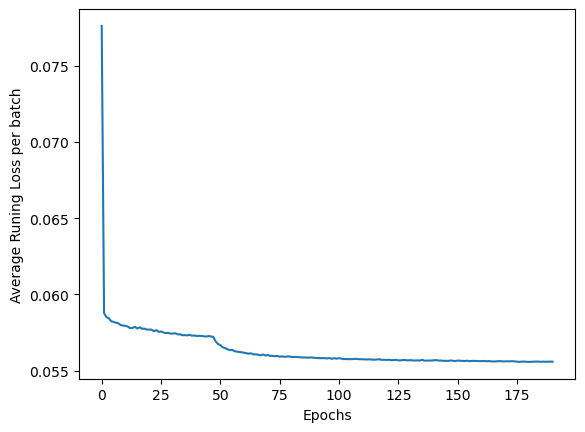

In [23]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [24]:
torch.save(final_model, 'model_100206_13g_07.pt')